In [1]:
from operator import itemgetter
from itertools import count, chain
from collections import Counter, defaultdict
import random
import dynet as dy
import numpy as np
import re

train_file = "data/train1.oracle"
dev_file = "data/dev1.oracle"
test_file = "data/test1.oracle"
cluster_file = "data/bllip-clusters"

WORD_DIM = 50
LSTM_DIM = 256 # same for input and hidden layers
ACTION_DIM = 16 # dimension for action embedding

class Vocab:
  def __init__(self, w2i):
    self.w2i = dict(w2i)
    self.i2w = {i:w for w,i in w2i.items()}

  @classmethod
  def from_list(cls, words):
    w2i = {}
    idx = 0
    for word in words:
      w2i[word] = idx
      idx += 1
    return Vocab(w2i)

  @classmethod
  def from_file(cls, vocab_fname):
    words = []
    with open(vocab_fname) as fh:
      for line in fh:
        line.strip()
        cluster, word, count = line.split("\t")
        words.append(word)
    return Vocab.from_list(words)  

  def merge_vocab(self, dic):
    self.w2i = Vocab(self.w2i.keys() + dic.keys()).w2i
    self.i2w = {i:w for w,i in self.w2i.items()}

  def size(self): return len(self.w2i.keys())

class TransitionParser:
  def __init__(self, model, cluster_filepath, vocab_acts, WORD_DIM=50, LSTM_DIM=256, ACTION_DIM=16):
    self.vocab = Vocab.from_file(cluster_filepath)
    #self.vocab.w2i["UNK"] = self.vocab.size() + 1 # add "UNK" to vocabulary... nope =/
    self.vocab_acts = vocab_acts
    self.vocab_NTs = Vocab.from_list(get_NTs(vocab_acts.w2i.keys()))
    self.act_NT_map = dict([[vocab_acts.w2i[x], self.vocab_NTs.w2i[x[3:-1]]] 
                            for x in vocab_acts.w2i if x.startswith("NT")])

    # parameters
    self.pW_comp = model.add_parameters((LSTM_DIM, LSTM_DIM*2))
    self.pb_comp = model.add_parameters((LSTM_DIM, ))
    self.pW_s2h = model.add_parameters((LSTM_DIM, LSTM_DIM ))
    self.pb_s2h = model.add_parameters((LSTM_DIM, ))
    self.pW_act = model.add_parameters((vocab_acts.size(), LSTM_DIM))
    self.pb_act = model.add_parameters((vocab_acts.size(), ))
    self.pempty_stack_emb = model.add_parameters((LSTM_DIM,)) # empty stack embedding /root guard
    # layers, in-dim, out-dim, model
    self.stackRNN = dy.CoupledLSTMBuilder(2, LSTM_DIM, LSTM_DIM, model)
    self.comp_LSTM_fwd = dy.CoupledLSTMBuilder(2, LSTM_DIM, LSTM_DIM, model)
    self.comp_LSTM_rev = dy.CoupledLSTMBuilder(2, LSTM_DIM, LSTM_DIM, model)
    self.cfsm = dy.ClassFactoredSoftmaxBuilder(LSTM_DIM, cluster_filepath, self.vocab.w2i, model);
    # lookup params
    self.WORDS_LOOKUP = model.add_lookup_parameters((self.vocab.size(), LSTM_DIM))
    self.ACT_LOOKUP = model.add_lookup_parameters((self.vocab_acts.size(), ACTION_DIM))
    self.NT_LOOKUP = model.add_lookup_parameters((self.vocab_NTs.size(), LSTM_DIM))
    self.pc = model

  def gen_setup(self, dropout=None):
    dy.renew_cg()
    stack = []
    stack.append((self.stackRNN.initial_state().add_input(dy.parameter(self.pempty_stack_emb)), 
      "<ROOT GUARD>")) # stack holds tuples: RNN state, string rep
    W_comp = dy.parameter(self.pW_comp)
    b_comp = dy.parameter(self.pb_comp)
    W_s2h = dy.parameter(self.pW_s2h)
    b_s2h = dy.parameter(self.pb_s2h)
    W_act = dy.parameter(self.pW_act)
    b_act = dy.parameter(self.pb_act)
    if dropout:
      self.stackRNN.set_dropout(dropout)
      self.comp_LSTM_fwd.set_dropout(dropout)
      self.comp_LSTM_rev.set_dropout(dropout)
    else:
      self.stackRNN.disable_dropout()
      self.comp_LSTM_fwd.disable_dropout()
      self.comp_LSTM_rev.disable_dropout()
    return [stack, # initial stack state,
            {"comp": (b_comp, W_comp), # bias and weight params for composition
              "s2h": (b_s2h, W_s2h), # bias and weight params for parser state
              "act": (b_act, W_act)}] # bias and weight params for predicting actions 

  def get_valid_actions(self, stack, open_nts, open_nt_ceil=100):
    # based on stack state, get valid actions
    valid_actions = []
    n_open_nts = len(open_nts)
    if n_open_nts < open_nt_ceil:  
      valid_actions += [v for k, v in self.vocab_acts.w2i.items() if k.startswith("NT")]
    if n_open_nts >= 1 and len(stack) > 1:
      valid_actions += [self.vocab_acts.w2i["SHIFT"]]
    if n_open_nts >= 1  and len(stack) > 1 \
        and len(stack) - 1 > open_nts[-1]:  # top element on stack can't be open NT
      valid_actions += [self.vocab_acts.w2i["REDUCE"]]
    return valid_actions

  def predict_action(self, stack, params, valid_actions, dropout=None):
    stack_embedding = stack[-1][0].output() 
    if dropout:
      stack_embedding = dy.dropout(stack_embedding, dropout)
    parser_state = dy.rectify(dy.affine_transform([params["s2h"][0], params["s2h"][1], stack_embedding]))
    logits = dy.affine_transform([params["act"][0], params["act"][1], parser_state])
    log_probs = dy.log_softmax(logits, valid_actions)
    return log_probs 

  def get_action(self, stack, params, valid_actions, n_actions, train_acts=None, dropout=None):
    action = valid_actions[0]
    loss = None
    if len(valid_actions) > 1:
      log_probs = self.predict_action(stack, params, valid_actions, dropout)
      if train_acts:
        try:
          action = self.vocab_acts.w2i[train_acts[n_actions]]
        except IndexError:
          raise Exception("Correct action list exhausted, but not in final parser state.")
        loss = dy.pick(log_probs, action)
      else:
        action = max(enumerate(log_probs.vec_value()), key=itemgetter(1))[0]
    return action, loss

  def do_action(self, stack, action, params, open_nts, n_terms, train_sent=None, dropout=None):
    if action in self.vocab_acts.i2w:
      act = action
      action = self.vocab_acts.i2w[action]
    else:
      act = self.vocab_acts.w2i[action]
    word, nt_index, loss = "", 0, None
    if action == "SHIFT":
      if train_sent:
        try:
          word = train_sent[n_terms]
        except IndexError:
          # raise Exception("Generated more terms than found in training sentence")
          pass
        if word not in self.vocab.w2i: ### for now, treat clusters as vocab
          if word.lower() in self.vocab.w2i:
            word = word.lower()
          else:
            #word = "UNK" ### - all words not in cluster file get UNKified - OR...
            word = random.sample(self.vocab.w2i.keys(), 1)[0] # ...replaced w/rando in-vocab wd
            # TODO: ^ this is not at all optimal, figure out how to fix
        loss = -self.cfsm.neg_log_softmax(stack[-1][0].output(), self.vocab.w2i[word])
      else:
        word = self.vocab.i2w[self.cfsm.sample(stack[-1][0].output())]
      word_embedding = self.WORDS_LOOKUP[self.vocab.w2i[word]]
      stack.append((stack[-1][0].add_input(word_embedding), word))
    elif action == "REDUCE":
      children = []
      last_nt_idx = open_nts.pop()
      while len(stack) > last_nt_idx + 1:
        children.append(stack.pop()) 
      children.reverse()
      last_nt = stack.pop()
      fwd = self.comp_LSTM_fwd.initial_state().add_input(last_nt[0].output())
      rev = self.comp_LSTM_rev.initial_state().add_input(last_nt[0].output())
      for i, child in enumerate(children):
        fwd.add_input(child[0].output())
        rev.add_input(children[len(children) - i - 1][0].output())
      cfwd = dy.dropout(fwd.output(), dropout) if dropout else fwd.output()
      crev = dy.dropout(rev.output(), dropout) if dropout else rev.output()
      bidir_rep = dy.concatenate([cfwd, crev])
      composed = dy.rectify(dy.affine_transform([params["comp"][0], 
                                                params["comp"][1], bidir_rep]))
      comp_str = last_nt[1] + " " + " ".join([child[1] for child in children]) + ")"
      stack.append((stack[-1][0].add_input(composed), comp_str))
    else: # open nonterminal
      NT = self.act_NT_map[act]
      nt_embedding = self.NT_LOOKUP[NT]
      stack.append((stack[-1][0].add_input(nt_embedding), "("+self.vocab_NTs.i2w[NT]))
      nt_index = len(stack) - 1
    return word, nt_index, loss

  def generate(self, train_sent=None, train_acts=None, dropout=None, nt_ceil=100):
    stack, params = self.gen_setup(dropout)
    terms, actions, open_nts, losses = [], [], [], []
    while len(terms) == 0 or len(stack) > 2 :
      valid_actions = self.get_valid_actions(stack, open_nts, nt_ceil)
      action, loss = self.get_action(stack, params, valid_actions, len(actions), train_acts, dropout)
      losses.append(loss) if loss else loss
      actions.append(action)
      term, nt_idx, loss = self.do_action(stack, action, params, open_nts, len(terms), train_sent, dropout)
      losses.append(loss) if loss else loss
      terms.append(term) if term else term
      open_nts.append(nt_idx) if nt_idx else nt_idx # open NT index is never 0
      if not train_sent:
        if len(terms) % 5 == 0:
          print(" ".join(terms))
    final_tree = stack[1][1]
    return final_tree, -dy.esum(losses) if losses else None

  def test(self, test_set):
    test_set.sort(key=lambda x: len(x[1]))
    corpus = [test_set[i] for i in range(len(test_set))]
    total_loss = 0.0
    words = 0
    i = 0
    for (_, s, a) in corpus:
      i += 1
      result, loss = self.generate(s, a)
      words += len(s)
      if loss is not None:
        total_loss += loss.scalar_value()
      if i % 50 == 0:
        print(total_loss / words)
        total_loss, words = 0, 0

  def train(self, corpus, trainer, dev=None, dropout=.3, epochs=3, max_iter=None):
    i = 0
    losses_graph = []
    results_store = []
    corpus.sort(key=lambda x: len(x[1])) 
    order = list(range(len(corpus)))
    for epoch in range(epochs):
      random.shuffle(order)
      shuffled_corpus = [corpus[i] for i in order]
      words = 0
      total_loss = 0.0
      for (_, s,a) in shuffled_corpus:
        result, loss = self.generate(s, a, dropout)
        words += len(s)
        if loss is not None:
          total_loss += loss.scalar_value()
          loss.backward()
          trainer.update()
        e = float(i) / len(corpus)
        if i % 25 == 0:
          losses_graph.append(total_loss / words)
          print('epoch {}: per-word loss: {}'.format(e, total_loss / words))
          if e > 1:
           result, loss= self.generate()
           print("   {}".format(result))
           results_store.append(result)
          words = 0
          total_loss = 0.0
        # if i % 500 == 0 and dev:
          # dev_words = 0
          # dev_loss = 0.0
          # for (_, ds, da) in dev:
            # result, loss = self.generate(ds, da)
            # dev_words += len(ds)
            # if loss is not None:
              # dev_loss += loss.scalar_value()
          # print('[validation] epoch {}: per-word loss: {}'.format(e, dev_loss / dev_words))
        i += 1
        if max_iter:
          if i >= max_iter:
            break
      if max_iter:
        if i >= max_iter:
          break
    return losses_graph, results_store

def read_oracle(fname, gen=True):
  sent_idx = 1 if gen else 4 # using non-UNKified sentences
  act_idx = 3 if gen else 5
  with open(fname) as fh:
    sent_ctr = 0
    tree, sent, acts = "", [], []
    for line in fh:
      sent_ctr += 1
      line = line.strip()
      if line.startswith("#"):
        sent_ctr = 0
        if tree:
          yield tree, sent, acts
        tree, sent, acts = line, [], []
      if sent_ctr == sent_idx:
        sent = line.split()
      if sent_ctr >= act_idx:
        if line:
          acts.append(line)

def load_data(tr=train_file, d=dev_file, ts=test_file):
  train, dev, test = [], [], []
  if tr:
    train = list(read_oracle(tr))
  if d:
    dev = list(read_oracle(d))
  if ts:
    test = list(read_oracle(ts))
  return train, dev, test

def create_vocab(all_terms):
  vocab = list(set(list(chain(*all_terms))))
  return Vocab.from_list(vocab)

def get_NTs(actions):
  NTs = []
  for act in actions:
    if act.startswith("NT"):
      NTs.append(act[3:-1])
  return NTs

In [2]:
# Train the model
print("lets go")
train, dev, test = load_data(train_file, dev_file, test_file)
print("done loading files")
vocab_acts = create_vocab([x[2] for x in train])
print("loading base model params")
model = dy.ParameterCollection()
print("done loading param graph")
tp = TransitionParser(model, cluster_file, vocab_acts)
print("loading model")
model.populate("epoch11.model")
print("done loading model")
# losses, results = tp.train(train, dy.SimpleSGDTrainer(model), dev, epochs=3)
# model.populate("shabba.model")
model.save("epoch11.model")
print("Done saving model!")

lets go
done loading files
loading base model params
done loading param graph
bob0
loading model


RuntimeError: Could not read model from epoch11.model

[16.310749053955078, 7.5704240122149065, 4.306818440444488, 5.175891101837158, 5.9765869073378735, 4.8175116740740265, 4.876853331923485, 5.440113775039974, 4.656709229151408, 4.648396356731442, 4.7237237023969065, 3.82617195977105, 4.39092510396784, 3.893747930239914, 4.651157840092977, 4.836745023727417, 4.432012681719623, 4.487669766282236, 5.073818479735276, 4.922428687413533, 3.8695394022124154, 4.57090816622466, 4.357139234125179, 3.8868870735168457, 3.860529268887026, 4.198434967041016, 3.7908260369602638, 3.643617996080654, 3.8717567814721003, 3.3840293384887077, 4.811170435571051, 4.086638779174991, 4.217640302902044, 3.814608630600509, 3.6164834153267646, 4.023435288005405, 4.844790556214073, 4.086725532192073, 3.5339399123376656, 4.081922294663602, 3.731634592126917, 3.966839241259026, 4.271126059001078, 4.40050806586198, 3.3222726415271406, 4.33611555840518, 4.113950344356331, 4.4647652990866025, 4.755603873729706, 4.871568429881129, 4.195627617835998, 3.378002807497978, 3.

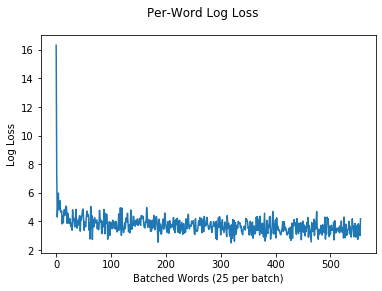

In [33]:
import matplotlib.pyplot as plt
prev_loss = [16.310749053955078, 7.5704240122149065, 4.306818440444488, 5.175891101837158, 5.9765869073378735, 4.8175116740740265, 4.876853331923485, 5.440113775039974, 4.656709229151408, 4.648396356731442, 4.7237237023969065, 3.82617195977105, 4.39092510396784, 3.893747930239914, 4.651157840092977, 4.836745023727417, 4.432012681719623, 4.487669766282236, 5.073818479735276, 4.922428687413533, 3.8695394022124154, 4.57090816622466, 4.357139234125179, 3.8868870735168457, 3.860529268887026, 4.198434967041016, 3.7908260369602638, 3.643617996080654, 3.8717567814721003, 3.3840293384887077, 4.811170435571051, 4.086638779174991, 4.217640302902044, 3.814608630600509, 3.6164834153267646, 4.023435288005405, 4.844790556214073, 4.086725532192073, 3.5339399123376656, 4.081922294663602, 3.731634592126917, 3.966839241259026, 4.271126059001078, 4.40050806586198, 3.3222726415271406, 4.33611555840518, 4.113950344356331, 4.4647652990866025, 4.755603873729706, 4.871568429881129, 4.195627617835998, 3.378002807497978, 3.9619275816025272, 3.7214300846231394, 3.6283928417577975, 4.292386353810628, 4.72835774179818, 4.357748922374514, 4.491729819256326, 4.36438123478609, 3.385259889421009, 3.8775943463498894, 2.7735102488324532, 5.046516490269856, 3.531767146688112, 4.399376803596548, 2.7384557287201625, 4.011950678529993, 4.108599496610237, 3.618754958794787, 4.265545726667905, 4.002274027769117, 3.889943582910887, 3.976684497881539, 4.096668903994712, 3.488561481725974, 3.9126011009874015, 3.4213343411684036, 3.5152560021426225, 4.775047930511269, 4.265729624754305, 3.9515680966976876, 4.088831845257017, 3.1495389520076285, 3.178407877878426, 3.9764681422349177, 3.6363779107729592, 4.83605893202654, 4.329062640211965, 3.133599383690778, 4.5593295130931155, 3.8522115177578398, 4.492373304429397, 4.032533403100638, 2.759404429188975, 3.675924848765135, 3.4155947053936164, 3.9852742119658764, 3.024623158905241, 3.9309476912021637, 3.9033728094661937, 3.590115566381672, 3.4870376969776014, 4.086653783723905, 3.9403827869339496, 4.005422641491068, 3.5123180393129587, 3.910077383192323, 3.4701238285963703, 4.006687773797745, 3.826869253759031, 3.263009923825161, 3.4017996200143474, 3.3723682466941542, 4.523498915337227, 3.4016763300135517, 3.5602058470249176, 4.953028672120788, 3.869492976418857, 3.0220759220612354, 4.933207349777222, 3.6657838442968944, 3.3980517387390137, 3.2196120859562667, 3.486700248718262, 3.8957977034151554, 3.49120112026439, 4.122286879631781, 4.257029090853904, 3.95838262766776, 4.568411073019338, 3.8608913746009876, 3.2689270565384314, 3.60369134087094, 3.765269476846354, 3.2058101892471313, 4.798249285148851, 4.612913031327097, 3.453306902879439, 3.822924815433126, 3.7009671903124044, 4.3578668158987295, 4.013612043222732, 3.8322338814948016, 3.6557981151424044, 4.072547737432986, 3.891694041147624, 3.7980913012775024, 4.169210147857666, 3.7217281490564345, 3.7743965810345066, 3.9838729124320182, 4.213593636372293, 3.8926416709099287, 3.7244219132411627, 4.408652540566265, 4.3751698131403645, 4.202524538753795, 4.373581744254904, 4.193492107254138, 3.716879486141348, 3.5498716750112522, 3.557728412823799, 3.9765745460009967, 3.9319859560388717, 4.971627716986549, 4.255296969817857, 3.5978325137385614, 4.132960288755355, 4.0877099883729135, 3.5970562476261407, 4.0942066015786684, 3.299349985049881, 3.3396032735949657, 3.331381177290892, 4.072034532373602, 3.546564049190945, 3.758274638489501, 4.423984407439945, 3.7152109761391916, 3.4214414736581227, 3.6458092252892182, 4.316880811190774, 4.328765945081358, 3.950222619374593, 3.1523798555135727, 2.5486560786092602, 3.8937622279655644, 4.160418247613381, 3.333689898413581, 3.807230105647793, 3.158713623993379, 3.1043067836761473, 3.616100945965997, 3.921413609679316, 4.163060827860757, 3.458449649059866, 3.8314786710237203, 4.584638625383377, 4.194726094034792, 3.707212622736541, 3.462606833415961, 3.225393700751529, 3.75883174081992, 3.9891520911141445, 3.188227449791341, 3.174139256477356, 4.047922579778565, 3.536093922827741, 3.808103261455413, 3.630443505550686, 3.5865876095317235, 3.6827809247103604, 3.927507546769471, 4.277017632151038, 3.40304491519928, 4.041062235053069, 3.212085236443414, 3.7512895266215005, 4.164691473077411, 3.8184716926784965, 4.2156313711597075, 3.2484683273430157, 3.999537793365685, 3.2119761613699107, 4.084419616306101, 3.15430954449317, 3.4332745829715003, 3.67519751093746, 3.94141450929053, 3.3537247130211365, 3.1007219727631585, 3.8401439205096786, 3.8326490589550564, 3.1871979236602783, 3.362667173534245, 3.2503225421905517, 4.178964740889413, 3.7179705120666684, 3.491596348892302, 4.028384585129587, 4.509170639682823, 3.7519686937332155, 3.4766696414282157, 3.733062360904835, 3.6994689892078267, 3.651370332354591, 4.024578017910032, 3.83455710278617, 3.9068571117752833, 4.0475623200579385, 3.6565193784409673, 3.1739240588998436, 3.095630371017961, 4.186692351200541, 3.387440555974057, 3.3255452259330993, 3.2942734724320704, 3.3852671290473113, 3.7635394838121203, 4.052356169205304, 3.721320427954197, 4.282102697236198, 3.9802519536157797, 3.701939843251155, 4.2107022089987804, 3.2120768082369664, 3.897007490842397, 4.106627875000891, 3.279541761644425, 4.344989170301829, 4.045439600061488, 3.6719313296111853, 3.6929147572352967, 3.833417473612605, 4.283525591311247, 3.790241053004465, 3.731122271767978]
epoch11_losses = prev_loss + losses
fig = plt.figure()
plt.plot([i for i in range(len(epoch11_losses))], epoch11_losses)
fig.suptitle("Per-Word Log Loss")
plt.xlabel("Batched Words (25 per batch)")
plt.ylabel("Log Loss")

(S (NP you) (VP do n't (VP know)) .)
(S (NP he) (VP 's (ADJP right)) .)
(S (NP this) (VP are (VP crossing (NP the box))) ?)
(FRAG (NP baseball University) .)
(S (NP that) (VP want (NP some coffee)) .)
(S (NP it) (VP said (NP some macaroni)) .)
(INTJ much-faster whoops .)
(FRAG (NP dissimilar) , (NP ball) .)
(S (NP I) (VP take (NP that) (PRT out)) .)
(FRAG (NP some hot-water) ?)
(S (NP that) (VP want (NP shaving surprise)) .)
(S (NP you) (VP do n't (VP think (SBAR (S (NP you) (VP can (VP put (NP a cup) (PRT in))))))) .)
(S (NP you) (VP do n't (VP know)) .)
(S (NP I) (VP did n't (VP see (NP mussels))) .)
(S (NP I) (VP 're (VP going)) .)
(S (NP you) (VP have (NP clay)) .)
(S (NP that) (VP 's (ADJP dirty)) ?)
(S (NP you) (VP do n't (VP know)) .)


In [45]:
for (_, s, a) in train[1000:1010]:
    result, loss = tp.generate(s, a, 0.3)

['NT(S)', 'NT(VP)', 'SHIFT', 'NT(SBAR)', 'NT(WHNP)', 'SHIFT', 'REDUCE', 'NT(S)', 'NT(VP)', 'SHIFT', 'NT(ADVP)', 'SHIFT', 'REDUCE', 'REDUCE', 'REDUCE', 'REDUCE', 'REDUCE', 'SHIFT', 'REDUCE']
(S (VP see (SBAR (WHNP what) (S (VP 's (ADVP inside))))) .)
6.4827423095703125
['NT(S)', 'NT(VP)', 'SHIFT', 'NT(NP)', 'SHIFT', 'REDUCE', 'NT(NP)', 'SHIFT', 'SHIFT', 'REDUCE', 'REDUCE', 'SHIFT', 'REDUCE']
(S (VP is (NP that) (NP his name)) ?)
3.3970584869384766
['NT(INTJ)', 'SHIFT', 'REDUCE', 'SHIFT', 'NT(FRAG)', 'NT(NP)', 'SHIFT', 'SHIFT', 'REDUCE', 'SHIFT', 'REDUCE']
(INTJ hello)
1.031151008605957
['NT(SBAR)', 'NT(WHADVP)', 'SHIFT', 'REDUCE', 'NT(S)', 'NT(VP)', 'SHIFT', 'NT(NP)', 'SHIFT', 'REDUCE', 'NT(ADVP)', 'SHIFT', 'REDUCE', 'REDUCE', 'REDUCE', 'SHIFT', 'REDUCE']
(SBAR (WHADVP how) (S (VP are (NP you) (ADVP today))) ?)
4.040924072265625
['NT(SBAR)', 'NT(WHNP)', 'SHIFT', 'REDUCE', 'NT(S)', 'NT(VP)', 'SHIFT', 'NT(NP)', 'SHIFT', 'REDUCE', 'NT(VP)', 'SHIFT', 'REDUCE', 'REDUCE', 'REDUCE', 'SHIFT', '

In [4]:
tp.test(test)

4.591711072921753
4.15346061706543
4.532235155105591
4.761990337371826
5.717469486823449
6.261814101537069
6.3433059851328535
5.234972131466437
4.952698490619659
4.015413823127747
3.3356433081626893
5.252345931529999
4.559257632161414
4.290288427352905
4.78341236114502
4.615433944702149
4.513944219589233
5.394028778076172
4.905654796926152
4.640450263023377
4.146114813486735
4.635127873420715
4.526238568623861
4.442049902961368
4.078441606249128
4.662068770272391
3.8294444002423966
4.283405095509121
4.260055736619599
4.295467768907547
4.161488753557205
4.755037401957685
3.7815959241655137
4.2198015138838025
3.43886921955989
3.9741594256945754
4.588756031843465
4.766299750374966
5.105603967903263


In [6]:
print(vocab_acts.i2w)

{0: 'NT(WHADJP)', 1: 'NT(NP)', 2: 'NT(PRT)', 3: 'REDUCE', 4: 'NT(ADVP)', 5: 'NT(INTJ)', 6: 'NT(ADJP)', 7: 'NT(WHPP)', 8: 'NT(FRAG)', 9: 'NT(S)', 10: 'NT(VP)', 11: 'NT(WHNP)', 12: 'SHIFT', 13: 'NT(WHADVP)', 14: 'NT(SBAR)', 15: 'NT(PP)'}


In [7]:
print(vocab_acts.w2i)

{'NT(WHADJP)': 0, 'NT(NP)': 1, 'NT(PRT)': 2, 'REDUCE': 3, 'NT(ADVP)': 4, 'NT(INTJ)': 5, 'NT(ADJP)': 6, 'NT(WHPP)': 7, 'NT(FRAG)': 8, 'NT(S)': 9, 'NT(VP)': 10, 'NT(WHNP)': 11, 'SHIFT': 12, 'NT(WHADVP)': 13, 'NT(SBAR)': 14, 'NT(PP)': 15}


In [9]:
print(tp.vocab.size())

316710


In [32]:
# This cell computes overlap in words in Adam corpus to Brown cluster
words_map = {}
corpus = train + test + dev
for (_, s, _) in corpus:
    for word in s:
        if word in tp.vocab.w2i:
            words_map[word] = 1
        else:
            words_map[word] = -1
in_word, out_word = 0, 0
for word in words_map:
    if words_map[word] == 1:
        in_word += 1
    else:
        out_word += 1
print(in_word, out_word)

1889 96
